In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle



# using the SQLite Table to read data.
con = sqlite3.connect('final.sqlite') 
#taking 5000 random reviews
#sorting the data using time stamp
finalDF = pd.read_sql_query(""" SELECT * FROM Reviews ORDER BY TIME ASC, RANDOM() LIMIT 5000 """, con)

finalDF.head(10)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
2,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
3,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
4,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...
5,346116,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,positive,947376000,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,one movi movi collect fill comedi action whate...
6,346041,374343,B00004CI84,A1B2IZU1JLZA6,Wes,19,23,negative,948240000,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very...",alway enjoy movi funni entertain didnt hesit p...
7,70688,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,positive,948672000,A sure death for flies,I bought a few of these after my apartment was...,bought apart infest fruit fli hour trap mani f...
8,346141,374450,B00004CI84,ACJR7EQF9S6FP,Jeremy Robertson,2,3,positive,951523200,Bettlejuice...Bettlejuice...BETTLEJUICE!,What happens when you say his name three times...,happen say name three time michael keaten star...
9,417883,451903,B00004CXX9,A2DEE7F9XKP3ZR,jerome,0,1,positive,959990400,Research,I'm getting crazy.<p>Is it really impossible t...,get crazi realli imposs today find french vhs ...


In [3]:
#applying bag of words
count_vect = CountVectorizer() #convert review text into sparse vectors
bow_counts = count_vect.fit_transform(finalDF['CleanedText'].values)#return the values into matrix
print("the type of count vectorizer ",type(bow_counts))
print("the shape of out text BOW vectorizer ",bow_counts.get_shape())
print("the number of unique words ", bow_counts.get_shape()[1])
print(bow_counts[90])
type(bow_counts)

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (5000, 11507)
the number of unique words  11507
  (0, 8745)	1
  (0, 8052)	1
  (0, 3488)	1
  (0, 5964)	1


scipy.sparse.csr.csr_matrix

In [11]:
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
# define column names
# create design matrix X and target vector y
X = bow_counts
y = np.array(finalDF['Score']) # target function y consits score label


The optimal number of neighbors is 7.


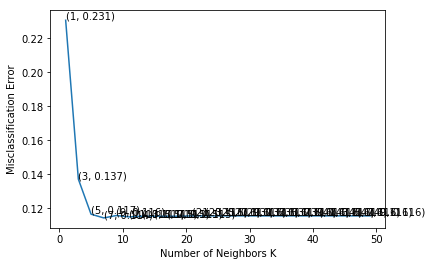

the misclassification error for each k value is :  [0.231 0.137 0.117 0.114 0.116 0.115 0.115 0.115 0.115 0.115 0.116 0.116
 0.116 0.116 0.116 0.116 0.116 0.116 0.116 0.116 0.116 0.116 0.116 0.116
 0.116]


In [12]:
from sklearn import cross_validation
from sklearn.model_selection import TimeSeriesSplit

#split the data set into train and test and test size=0.3
X_1, X_test, y_1, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=0)

# split the train data set into cross validation using time series split with 10 splits
tscv=TimeSeriesSplit(n_splits=10)

# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='brute')# applying brute force technique.
    scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# finding better k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

In [13]:
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model
knn_optimal.fit(X_1, y_1)

# predict the response
pred = knn_optimal.predict(X_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 7 is 86.800000%


In [14]:
#Applying TFIDF on Knn
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))#converting review into sparse vector
final_tf_idf = tf_idf_vect.fit_transform(finalDF['CleanedText'].values)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (5000, 152020)
the number of unique words including both unigrams and bigrams  152020



The optimal number of neighbors is 7.


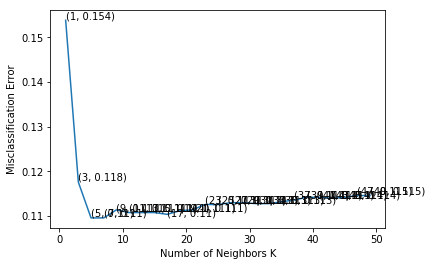

the misclassification error for each k value is :  [0.154 0.118 0.11  0.11  0.111 0.111 0.111 0.111 0.11  0.111 0.111 0.113
 0.113 0.113 0.113 0.113 0.113 0.113 0.114 0.114 0.114 0.114 0.114 0.115
 0.115]


In [15]:
X = final_tf_idf
y = np.array(finalDF['Score'])

#split the data set into train and test and test size=0.3
X_1, X_test, y_1, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=0)

tscv=TimeSeriesSplit(n_splits=10) #applying time series split on the training data with 10 splits.

# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='brute')
    scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')#adding x and y labels
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

In [16]:
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model
knn_optimal.fit(X_1, y_1)

# predict the response
pred = knn_optimal.predict(X_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 7 is 87.600000%


In [17]:
# Train own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in finalDF['CleanedText'].values:
    list_of_sent.append(sent.split())
print(finalDF['CleanedText'].values[0])
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

witti littl book make son laugh loud recit car drive along alway sing refrain hes learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg
number of words that occured minimum 5 times  3833
sample words  ['littl', 'book', 'make', 'son', 'laugh', 'loud', 'car', 'drive', 'along', 'alway', 'sing', 'hes', 'learn', 'india', 'love', 'new', 'word', 'introduc', 'silli', 'classic', 'will', 'bet', 'still', 'abl', 'memori', 'colleg', 'rememb', 'see', 'show', 'air', 'televis', 'year', 'ago', 'child', 'sister', 'later', 'bought', 'day', 'thirti', 'someth', 'use', 'seri', 'song', 'student', 'teach', 'turn', 'whole', 'school', 'purchas', 'children']


In [18]:
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))
type(sent_vectors)

5000
50


list


The optimal number of neighbors is 29.


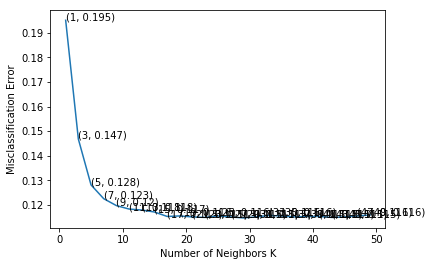

the misclassification error for each k value is :  [0.195 0.147 0.128 0.123 0.12  0.118 0.118 0.117 0.115 0.116 0.115 0.115
 0.116 0.115 0.115 0.115 0.116 0.116 0.115 0.115 0.115 0.115 0.115 0.116
 0.116]


In [19]:
X = sent_vectors
y = np.array(finalDF['Score'])

#split the data set into train and test with test size=0.3
X_1, X_test, y_1, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=0)

# split the train data set into cross validation using time series split with 10 splits.
tscv=TimeSeriesSplit(n_splits=10)

# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='brute')
    scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

In [20]:
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model
knn_optimal.fit(X_1, y_1)

# predict the response
pred = knn_optimal.predict(X_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 29 is 86.600000%


In [21]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
type(tfidf_feat)

list


The optimal number of neighbors is 37.


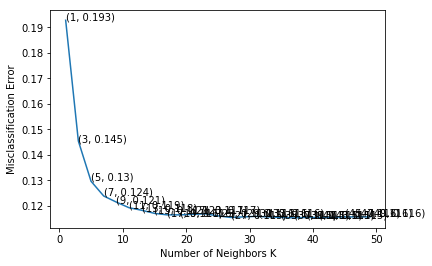

the misclassification error for each k value is :  [0.193 0.145 0.13  0.124 0.121 0.119 0.118 0.117 0.116 0.116 0.117 0.117
 0.116 0.115 0.116 0.116 0.116 0.115 0.115 0.115 0.115 0.115 0.116 0.116
 0.116]


In [23]:
X = tfidf_sent_vectors
y = np.array(finalDF['Score'])

#split the data set into train and test with test size=0.3
X_1, X_test, y_1, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=0)
# split the train data set into cross validation using time series split with 10 splits
tscv=TimeSeriesSplit(n_splits=10)

# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='brute')
    scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

In [24]:
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model
knn_optimal.fit(X_1, y_1)

# predict the response
pred = knn_optimal.predict(X_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 37 is 87.000000%



The optimal number of neighbors is 7.


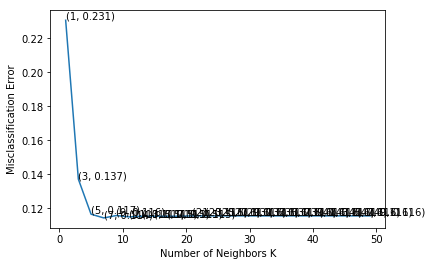

the misclassification error for each k value is :  [0.231 0.137 0.117 0.114 0.116 0.115 0.115 0.115 0.115 0.115 0.116 0.116
 0.116 0.116 0.116 0.116 0.116 0.116 0.116 0.116 0.116 0.116 0.116 0.116
 0.116]


In [30]:
from sklearn import cross_validation
from sklearn.model_selection import TimeSeriesSplit

X = bow_counts
y = np.array(finalDF['Score']) # target function y consits score label

#split the data set into train and test with test size=0.3
X_1, X_test, y_1, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=0)

# split the train data set into cross validation using time series split with 10 splits
tscv=TimeSeriesSplit(n_splits=10)

# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree')
    scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

In [31]:
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model
knn_optimal.fit(X_1, y_1)

# predict the response
pred = knn_optimal.predict(X_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 7 is 86.800000%



The optimal number of neighbors is 7.


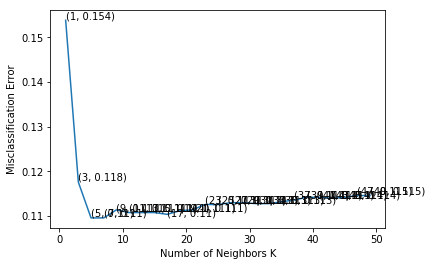

the misclassification error for each k value is :  [0.154 0.118 0.11  0.11  0.111 0.111 0.111 0.111 0.11  0.111 0.111 0.113
 0.113 0.113 0.113 0.113 0.113 0.113 0.114 0.114 0.114 0.114 0.114 0.115
 0.115]


In [39]:
X = final_tf_idf
y = np.array(finalDF['Score'])

#split the data set into train and test and test size=0.3
X_1, X_test, y_1, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=0)
# split the train data set into cross validation using time series split with 10 splits
tscv=TimeSeriesSplit(n_splits=10)

# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree')
    scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

In [40]:
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model
knn_optimal.fit(X_1, y_1)

# predict the response
pred = knn_optimal.predict(X_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 7 is 87.600000%



The optimal number of neighbors is 29.


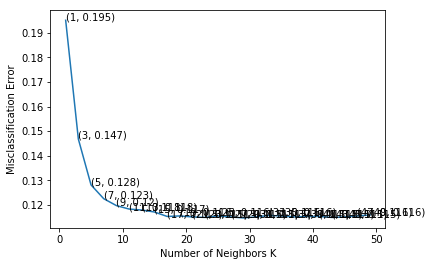

the misclassification error for each k value is :  [0.195 0.147 0.128 0.123 0.12  0.118 0.118 0.117 0.115 0.116 0.115 0.115
 0.116 0.115 0.115 0.115 0.116 0.116 0.115 0.115 0.115 0.115 0.115 0.116
 0.116]


In [33]:
X = sent_vectors
y = np.array(finalDF['Score'])

#split the data set into train and test and test size=0.3
X_1, X_test, y_1, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=0)
# split the train data set into cross validation using time series split with 10 splits
tscv=TimeSeriesSplit(n_splits=10)

# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree')
    scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

In [34]:
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model
knn_optimal.fit(X_1, y_1)

# predict the response
pred = knn_optimal.predict(X_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 29 is 86.600000%



The optimal number of neighbors is 37.


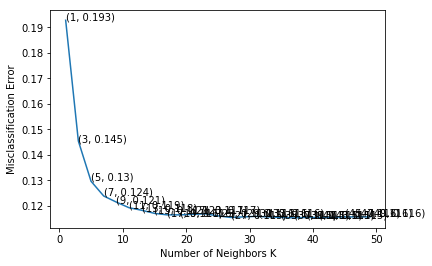

the misclassification error for each k value is :  [0.193 0.145 0.13  0.124 0.121 0.119 0.118 0.117 0.116 0.116 0.117 0.117
 0.116 0.115 0.116 0.116 0.116 0.115 0.115 0.115 0.115 0.115 0.116 0.116
 0.116]


In [35]:
X = tfidf_sent_vectors
y = np.array(finalDF['Score'])

#split the data set into train and test and test size=0.3
X_1, X_test, y_1, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=0)
# split the train data set into cross validation using time series split with 10 splits
tscv=TimeSeriesSplit(n_splits=10)

# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree')
    scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

In [36]:
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model
knn_optimal.fit(X_1, y_1)

# predict the response
pred = knn_optimal.predict(X_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 37 is 87.000000%


In [41]:
#Finally I observerd vectorization techniques with bruteforce and kd tree gives same accuracy with same k Value.